# Survival Analysis for Individual Patient Data of Acid Sphingomyelinase Deficiency (ASMD)


## Background

Sanofi engaged ISMS to develop a patient pool model for Acid Sphingomyelinase Deficiency (ASMD). This disease exhibits significant variability in key parameters, including clinical severity, age of onset, and survival. The variability extends across subtypes (A, A/B, and B), with subtype B further differing by pediatric versus adult onset.

Using mean values to model these parameters would overlook this heterogeneity, leading to loss of detail in patient pool classifications (onset, diagnosis, survival) across age groups. To address this, a probabilistic approach was implemented to better capture variability within and between subgroups.

## Input Data

The age-at-diagnosis dataset was extracted from the [article](https://www.sciencedirect.com/science/article/pii/S1096719216300580). 

In [4]:
# Load age at diagnosis dataset in Excel
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lifelines


In [5]:
diagnosis_age_df = pd.read_excel('age-at-diagnosis-asmd.xlsx')

In [6]:
diagnosis_age_df.head()

,Time since birth (year),Diagnosis,AB,CH
0,0.10,1,1,0
1,0.28,1,1,0
2,0.36,1,1,0
3,0.45,1,1,0
4,0.45,1,1,0


## Perform KM survival analysis

In [7]:
from lifelines import KaplanMeierFitter # for Kaplan Meier estimator
from matplotlib import pyplot as plt
from lifelines.utils import median_survival_times 

/var/folders/b8/9ymtxc2j7rb00xx34s753cwc0000gn/T/ipykernel_79769/41739333.py:30: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="best")


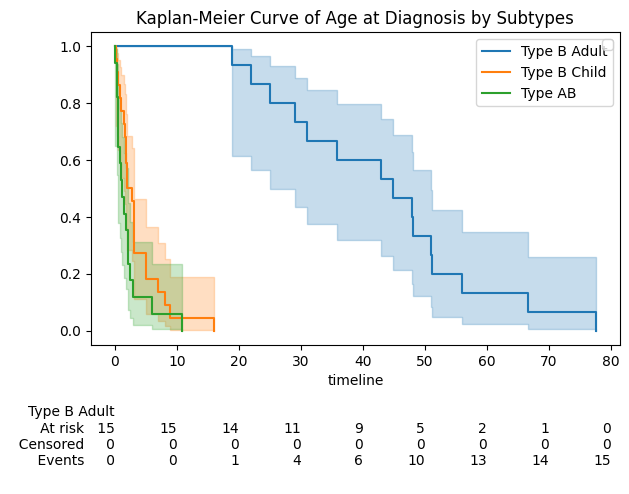

In [8]:
ax = plt.subplot(111) # To put the legend outside the plot 

# Subset by subtypes - index the rows with the condition
# AB == 0 and CH == 0 means type B adult
# AB == 0 and CH == 1 means type B child
# AB == 1 means type AB
type_b_adult = (diagnosis_age_df["AB"] == 0) & (diagnosis_age_df["CH"] == 0)
type_b_child = (diagnosis_age_df["AB"] == 0) & (diagnosis_age_df["CH"] == 1)
type_ab = (diagnosis_age_df["AB"] == 1)

# Instantiate the class to create an object
kmf = KaplanMeierFitter()  

# Define the time and event
T = diagnosis_age_df["Time since birth (year)"] 
E = diagnosis_age_df["Diagnosis"]  

# Fit the data into the model
kmf.fit(T[type_b_adult], event_observed=E[type_b_adult], label="Type B Adult")
kmf.plot_survival_function(ax=ax, at_risk_counts=True) 

kmf.fit(T[type_b_child], event_observed=E[type_b_child], label="Type B Child")
kmf.plot_survival_function(ax=ax, at_risk_counts=False)

kmf.fit(T[type_ab], event_observed=E[type_ab], label="Type AB")
kmf.plot_survival_function(ax=ax, at_risk_counts=False)

plt.tight_layout()
plt.title("Kaplan-Meier Curve of Age at Diagnosis by Subtypes")
plt.legend(loc="best")

## Compare the survival curves of different subtypes using log-rank test

In [9]:
from lifelines.statistics import logrank_test 

In [10]:
# Test at the 5% significance level 
diag_log_rank = logrank_test(T[type_b_adult],
                             T[type_b_child],
                             E[type_b_adult],
                             E[type_b_child],
                             alpha=0.05)

In [11]:
diag_log_rank.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.05
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.05 <0.005     29.70

## Perform parametric regression analysis to estimate the survival function

Fit various parametric models to the data and compare the goodness of fit using AIC, including Weibull, Gompertz, Exponential, and Log-normal models.

In [12]:
from lifelines import (WeibullFitter, ExponentialFitter, LogNormalFitter, LogLogisticFitter, NelsonAalenFitter, CoxPHFitter, GeneralizedGammaFitter)

Text(0.5, 0.5, 'AIC: 368.07720655554164')

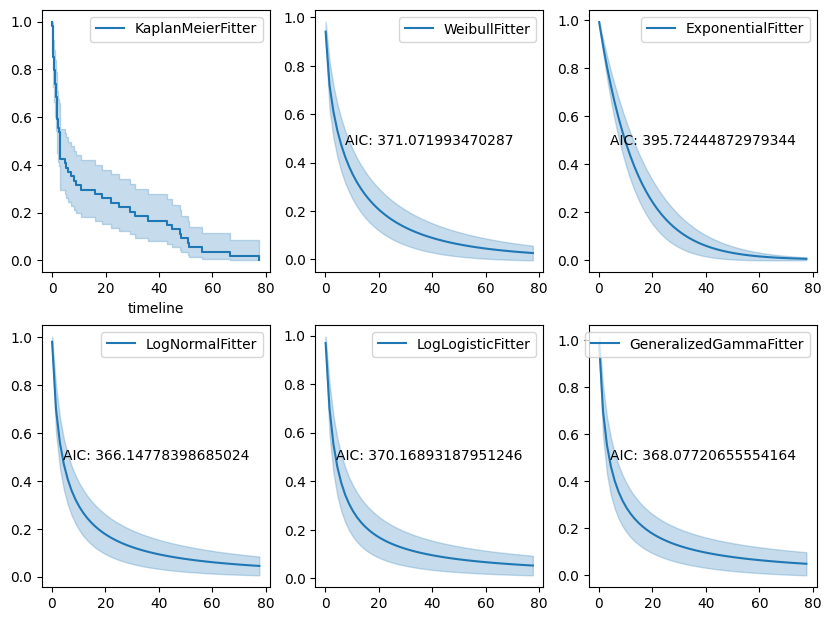

In [13]:
fig, axes = plt.subplots(2, 3, figsize=(10, 7.5))

# Kaplan-Meier Fitter 
kmf_surv = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter') 
kmf_surv.plot_survival_function(ax=axes[0][0])

# Weibull Fitter
wbf_surv = WeibullFitter().fit(T, E, label='WeibullFitter')
wbf_surv.plot_survival_function(ax=axes[0][1])
# Print AIC in plot
axes[0][1].text(0.5, 0.5, f"AIC: {wbf_surv.AIC_}", horizontalalignment='center', verticalalignment='center', transform=axes[0][1].transAxes)

# Exponential Fitter
exf_surv = ExponentialFitter().fit(T, E, label='ExponentialFitter')
exf_surv.plot_survival_function(ax=axes[0][2])
axes[0][2].text(0.5, 0.5, f"AIC: {exf_surv.AIC_}", horizontalalignment='center', verticalalignment='center', transform=axes[0][2].transAxes)

# Log-Normal Fitter
lnf_surv = LogNormalFitter().fit(T, E, label='LogNormalFitter')
lnf_surv.plot_survival_function(ax=axes[1][0])
axes[1][0].text(0.5, 0.5, f"AIC: {lnf_surv.AIC_}", horizontalalignment='center', verticalalignment='center', transform=axes[1][0].transAxes)

# Log Logistic Fitter
llf_surv = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
llf_surv.plot_survival_function(ax=axes[1][1])
axes[1][1].text(0.5, 0.5, f"AIC: {llf_surv.AIC_}", horizontalalignment='center', verticalalignment='center', transform=axes[1][1].transAxes)

# Generalized Gamma Fitter
ggf_surv = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')
ggf_surv.plot_survival_function(ax=axes[1][2])
axes[1][2].text(0.5, 0.5, f"AIC: {ggf_surv.AIC_}", horizontalalignment='center', verticalalignment='center', transform=axes[1][2].transAxes)

In [14]:
# Manually compare AIC values
models = {'Weibull': wbf_surv.AIC_, 'Exponential': exf_surv.AIC_, 'Log-Normal': lnf_surv.AIC_, 'Log-Logistic': llf_surv.AIC_, 'Generalized Gamma': ggf_surv.AIC_}
min_model = min(models, key=models.get)
print(f"Model with minimum AIC: {min_model}")

Model with minimum AIC: Log-Normal


## Select the best model and estimate the survival function

In [15]:
from lifelines.utils import find_best_parametric_model

In [16]:
best_model, best_aic = find_best_parametric_model(T, E, scoring_method='AIC')

In [17]:
print(best_model, best_aic)

<lifelines.SplineFitter:"SplineFitter: 3 internal knot", fitted with 54 total observations, 0 right-censored observations> 359.53924981090427


<Axes: >

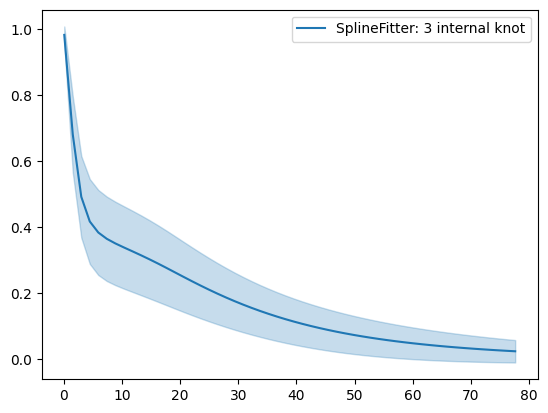

In [18]:
best_model.plot_survival_function() # Plot the survival function of the best model 

find_best_parametric_model() can select non-parametric SplineFitter if no parametric model fits well.

## Estimate the survival function for each subtype using log-normal model

In [21]:
from lifelines import LogNormalAFTFitter # Accelerated Failure Time model

lognorm_aft = LogNormalAFTFitter()  # Weibull Accelerated Failure Time model
lognorm_aft.fit(diagnosis_age_df, duration_col='Time since birth (year)', event_col='Diagnosis', formula="AB + CH")

<lifelines.LogNormalAFTFitter: fitted with 54 total observations, 0 right-censored observations>

In [22]:
lognorm_aft.print_summary()

<lifelines.LogNormalAFTFitter: fitted with 54 total observations, 0 right-censored observations>
             duration col = 'Time since birth (year)'
                event col = 'Diagnosis'
   number of observations = 54
number of events observed = 54
           log-likelihood = -148.72
         time fit was run = 2025-02-27 23:10:14 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    Intercept  3.69     40.12      0.25            3.20            4.18               24.63               65.35
       AB        -3.59      0.03      0.34           -4.26           -2.93                0.01                0.05
       CH        -2.92      0.05      0.32           -3.55           -2.28                0.03                0.10
sigma_ Intercept -0.04      0.96      0.10           -0.23            0.15                0.80                1.16

                  cmp to      z      p  -log2(p)
param  covariate                                
mu_    Intercept    0.00  14.83 <0.005    162.85
       AB           0.00 -10.52 <0.005     83.64
       CH           0.00  -9.04 <0.005     62.42
sigma_ Intercept    0.00  -0.38   0.70      0.50
---
Concordance = 0.75
AIC = 305.43
log-likelihood ratio test = 64.72 on 2 df
-log2(p) of ll-ratio test = 46.68